# Import Libraries

In [1]:
import math
import cmath
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import random

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import joblib

# Define Supplementary Functions

In [2]:
# Constant
mu = 4*math.pi*1E-7; #Magnetic Permeability (H/m)

# define frequency range in logarithmic scale
frequencies = np.logspace(-4,4, num=20,base=10)

# Forward model code returning apparent resistivities and phase
# modified from https://www.digitalearthlab.com/tutorial/tutorial-1d-mt-forward/
def mt1d(frequencies,resistivities,thicknesses,noise_mean=0,noise_std=0):

    n = len(resistivities);
    
    nf = len(frequencies)
    appres = np.zeros(nf)
    phases = np.zeros(nf)
    ii = 0
    
    for frequency in frequencies:   
        w =  2*math.pi*frequency;       
        impedances = list(range(n));
        #compute basement impedance
        impedances[n-1] = cmath.sqrt(w*mu*resistivities[n-1]*1j);

        s = np.random.normal(noise_mean, noise_std, 1)


        for j in range(n-2,-1,-1):
            resistivity = resistivities[j];
            thickness = thicknesses[j];

            # 3. Compute apparent resistivity from top layer impedance
            #Step 2. Iterate from bottom layer to top(not the basement) 
            # Step 2.1 Calculate the intrinsic impedance of current layer
            dj = cmath.sqrt((w * mu * (1.0/resistivity))*1j);
            wj = dj * resistivity;
            # Step 2.2 Calculate Exponential factor from intrinsic impedance
            ej = cmath.exp(-2*thickness*dj);                     

            # Step 2.3 Calculate reflection coeficient using current layer
            #          intrinsic impedance and the below layer impedance
            belowImpedance = impedances[j + 1];
            rj = (wj - belowImpedance)/(wj + belowImpedance);
            re = rj*ej; 
            Zj = wj * ((1 - re)/(1 + re));
            impedances[j] = Zj;    

        # Step 3. Compute apparent resistivity from top layer impedance
        Z = impedances[0] + s*impedances[0];
        absZ = abs(Z);
        apparentResistivity = (absZ * absZ)/(mu * w);
        phase = math.atan2(Z.imag, Z.real)
        
        appres[ii] = apparentResistivity
        phases[ii] = phase
        
        ii = ii+1
              
    return appres,phases

# plot 1d resistivity model
def plot1d_model(ax,y,linecolor='b',linestyle='-'):
    
    R1 = 10**y[0]
    R2 = 10**y[1]
    R3 = 10**y[2]
    d1 = 10**y[3]
    d2 = 10**y[4]
    
    ax.plot([R1,R1,R2,R2,R3,R3],[0.0001,d1,d1,d1+d2,d1+d2,d1+d2+100],linestyle+linecolor)
    ax.set_xscale('log')
#     ax.set_yscale('log')

    
    return
    
# plot comparison between predicted and true model, also their apparent resistivity and phase response
def compare_forward_response(y_pred,X,Y):
    
    pred_resistivities = 10**y_pred[0:3]
    pred_thicknessess = 10**y_pred[3:]
    
    [appres,phases]=mt1d(frequencies,pred_resistivities,pred_thicknessess)   

    plt.figure(figsize=(10, 5))
    G = gridspec.GridSpec(2, 2)

    axes_1 = plt.subplot(G[:, 0])
    plot1d_model(axes_1,Y)
    plot1d_model(axes_1,y_pred,linecolor='r',linestyle='--')

    axes_2 = plt.subplot(G[0, 1])

    axes_2.plot(frequencies,10**X[0:len(frequencies)], 'b', lw=2)
    axes_2.plot(frequencies,appres, '--r', lw=2)
    
    axes_3 = plt.subplot(G[1, 1])
    axes_3.plot(frequencies,X[len(frequencies):], 'b', lw=2)
    axes_3.plot(frequencies,phases, '--r', lw=2)
    
    axes_2.set_xscale('log')
    axes_3.set_xscale('log')
    axes_3.set_xlabel('frequency')
    axes_2.set_ylabel('Apparent Resistivity [$\Omega$m]')
    axes_3.set_ylabel('Phase [radian]')

    axes_1.legend(['True', 'Predicted'])
    axes_1.invert_yaxis()
    axes_1.set_xlabel('Resistivity [$\Omega$m]')
    axes_1.set_ylabel('Depth [m]')
    
    return

# evaluate predicted model apparent resistivity and phase misfit
# misfit = mean(absolute difference)
def eval_misfit(y_pred,X):
    
    Z = X.copy() # temporary copy to avoid modfying X globally
    colname = ['R1', 'R2', 'R3', 'd1', 'd2', 'Ra1', 'Ra2', 'Ra3', 'Ra4', 'Ra5', 'Ra6',
       'Ra7', 'Ra8', 'Ra9', 'Ra10', 'Ra11', 'Ra12', 'Ra13', 'Ra14', 'Ra15',
       'Ra16', 'Ra17', 'Ra18', 'Ra19', 'Ra20', 'P1', 'P2', 'P3', 'P4', 'P5',
       'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16',
       'P17', 'P18', 'P19', 'P20']
    df_pred = pd.DataFrame(columns=colname,index=range(0, int(len(y_pred))))

    nr = 3 # no. of layer resistivities
    nd = 2 # no. of layer thicknesses
    nf = len(frequencies) # no. of frequencies
    ii = 0

    for R1,R2,R3,d1,d2 in zip(10**y_pred[:,0],10**y_pred[:,1],10**y_pred[:,2],10**y_pred[:,3],10**y_pred[:,4]):

        resistivities = [R1, R2, R3];
        
        thicknesses = [d1, d2];

        [appres,phases] =mt1d(frequencies,resistivities,thicknesses)

        # save into the database

        # log layer true resistivities
        df_pred.iloc[ii,0:nr] = np.log10(resistivities)

        # log layer thicknesses
        df_pred.iloc[ii,nr:nr+nd] = np.log10(thicknesses)

        # log apparent resistivities    
#         df_pred.iloc[ii,nr+nd:nr+nd+nf] = np.log10(appres)
        df_pred.iloc[ii,nr+nd:nr+nd+nf] = appres # linear scale for evaluation

        # phases
        df_pred.iloc[ii,nr+nd+nf:nr+nd+nf+nf] = phases

        ii = ii+1
    
    Z.iloc[:,0:nf] = 10**X.iloc[:,0:nf]
    df_mean = (Z-df_pred.drop(columns=['R1','R2','R3','d1','d2'])).div(Z).abs().mean(axis=1)*100
    
#     df_pred.iloc[:,nr+nd:nr+nd+nf] = np.log10(df_pred.iloc[:,nr+nd:nr+nd+nf])

    misfit = round(df_mean.mean(axis=0),3) 
    

#     print(df_mean.idxmax())
#     print(df_mean.iloc[df_mean.idxmax()])
    
#     print(df_mean.idxmin())
#     print(df_mean.iloc[df_mean.idxmin()])
    
    df_min_max = [df_mean.idxmin(),df_mean.idxmax()]
    
    
    return df_pred,misfit,df_min_max


# Random Forest Training

In [3]:
# load training dataset

# no. of data : 100k Maybe too much for colab
# url = 'https://raw.githubusercontent.com/DHSaputera/MT1D_RandomForest/main/mt1d_training_random100k.csv' 

# no. of data : 10k
url = 'https://raw.githubusercontent.com/DHSaputera/MT1D_RandomForest/main/mt1d_training_random10k.csv'

# no. of data : 1k
# url = 'https://raw.githubusercontent.com/DHSaputera/MT1D_RandomForest/main/mt1d_training_random1k.csv'

df = pd.read_csv(url)

col_name = df.columns

# display(df)
# print(col_name)

In [4]:
# Data to predict = resistivities and thicknesses
Y = df[col_name[0:5]]

# display(Y)

# R = layer resistivities in log10
# d = layer thicknesses in log10

In [5]:
# Input Data = log10 apparent resistivities and phase
X = df[col_name[5:]]

# display(X)

# Ra = Apparent resistivity in log10
# P11 = Phase


In [6]:
# Random Forest Regressor
start = time.time()
model = RandomForestRegressor(n_estimators= 500,max_depth=1000, random_state=0)
model.fit(X,Y)

print('elapsed time = ',time.time()-start,'s')

elapsed time =  100.52218127250671 s


In [7]:
# Evaluate predicted model apparent resistivity and phase misfit from the data
# misfit = mean(absolute difference)

y_pred = model.predict(X)

df_pred,misfit,df_min_max_train = eval_misfit(y_pred,X)

print('average misfit = ',misfit,'%')

average misfit =  2.713 %


# Results and Plots

## Training Dataset

id =  555
misfit =  0.084 %


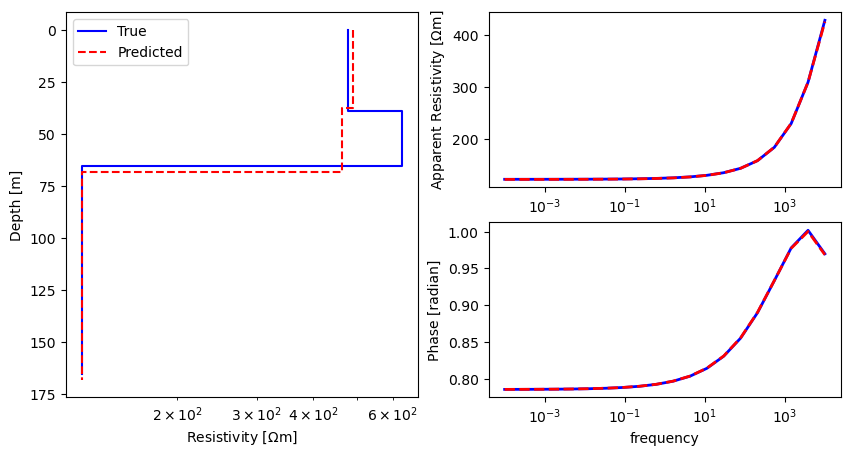

id =  670
misfit =  41.827 %


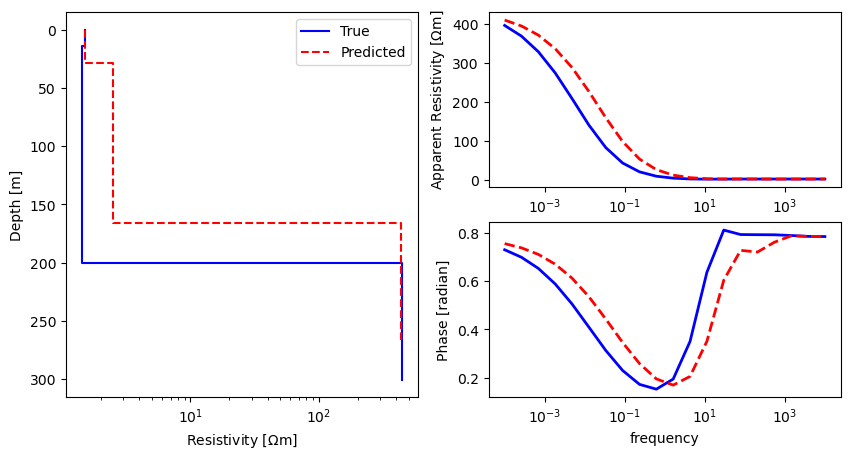

In [8]:
# randomly predict from training data
# for ii in range(0,11):
#     id_pred1 = random.randint(0,len(X)-1)

# best and worse prediction from training dataset
for id_pred1 in df_min_max_train:
    
    print('id = ',id_pred1)
    X_traintest = X.iloc[[id_pred1]]
    Y_traintest = Y.iloc[[id_pred1]]

    y_pred = model.predict(X_traintest)
#     y_preds = y_pred[id_pred1,:]

    df_pred,misfit,df_min_max = eval_misfit(y_pred,X_traintest.reset_index(drop=True))

    print('misfit = ',misfit,'%')

    compare_forward_response(y_pred.reshape(-1),X.iloc[id_pred1],Y.iloc[id_pred1].to_numpy())
    plt.show()

## Validation Dataset

In [9]:
# load validation dataset
url = 'https://raw.githubusercontent.com/DHSaputera/MT1D_RandomForest/main/mt1d_validation.csv'
df2 = pd.read_csv(url) # 100k data point

col_name = df2.columns

# display(df2)
# print(col_name)

In [10]:
# validation dataset and input

Y_validation = df2[col_name[0:5]]
X_validation = df2[col_name[5:]]


In [11]:
y_pred = model.predict(X_validation)

df_pred,misfit,df_min_max_val = eval_misfit(y_pred,X_validation)

print('average misfit = ', misfit,'%')

average misfit =  6.442 %


id =  917
misfit =  0.059 %


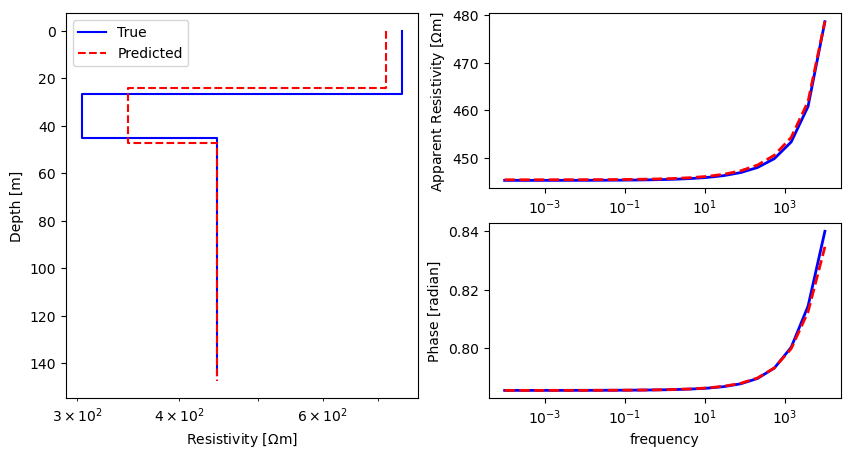

id =  576
misfit =  66.838 %


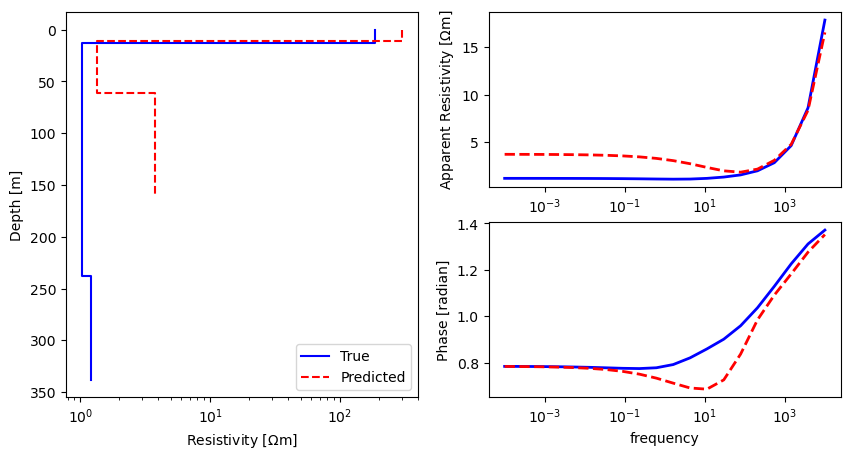

In [12]:
# randomly predict from validation dataset
# for ii in range(0,10):
#     id_pred_validation = random.randint(0,len(X_validation)-1)

# best and worse prediction from validation dataset
for id_pred_validation in df_min_max_val:

    print('id = ',id_pred_validation)

    y_pred = model.predict(X_validation.iloc[[id_pred_validation]])
    
    df_pred,misfit,df_min_max = eval_misfit(y_pred,X_validation.iloc[[id_pred_validation]].reset_index(drop=True))
    print('misfit = ', misfit,'%')

    compare_forward_response(y_pred.reshape(-1),X_validation.iloc[id_pred_validation],Y_validation.iloc[id_pred_validation])
    plt.show()

## Random New Dataset Test

In [13]:
# Create new random test data for subsurface with 3 layers

nr = 3 # 3 layers
nd = 2 # 2 layer thicknesses, the bottom layer has infinite thickness


# define frequency range in logarithmic scale
frequencies = np.logspace(-4,4, num=20,base=10)
# frequencies = [0.0001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,10000];

nf = len(frequencies)


# random number limit (in log10) and size

# resistivity limit
low_limit_r = 0
high_limit_r = 3

# thickness limit
low_limit_d = 1
high_limit_d = np.log10(300)

# define number of new test data
size = 1000

# define random resistivities with log-uniform distribution
R1s = 10**np.random.uniform(low_limit_r,high_limit_r,size)
R2s = 10**np.random.uniform(low_limit_r,high_limit_r,size)
R3s = 10**np.random.uniform(low_limit_r,high_limit_r,size)


# define random thicknesses with log-uniform distribution
d1s = 10**np.random.uniform(low_limit_d,high_limit_d,size)
d2s = 10**np.random.uniform(low_limit_d,high_limit_d,size)

# Gaussian noise mean and standard deviation 
noise_mean, noise_std = 0, 0.05 # mean and standard deviation for error percentage


df3 = pd.DataFrame(columns=df.columns,
                  index=range(0, int(size)))

print(size, ' data will be generated')

start = time.time();


ii = 0


for R1,R2,R3,d1,d2 in zip(R1s,R2s,R3s,d1s,d2s):
    
    resistivities = [R1, R2, R3];
    thicknesses = [d1, d2];

    [appres,phases] =mt1d(frequencies,resistivities,thicknesses,noise_mean=noise_mean,noise_std=noise_std)

    # save into the database
    
    # log layer true resistivities
    df3.iloc[ii,0:nr] = np.log10(resistivities)

    # log layer thicknesses
    df3.iloc[ii,nr:nr+nd] = np.log10(thicknesses)

    # log apparent resistivities    
    df3.iloc[ii,nr+nd:nr+nd+nf] = np.log10(appres)

    # phases
    df3.iloc[ii,nr+nd+nf:nr+nd+nf+nf] = phases

    ii = ii+1


print('');
print('time taken = ', time.time() - start, 's');


1000  data will be generated

time taken =  0.6526124477386475 s


In [14]:
Y_test = df3[col_name[0:5]]
X_test = df3[col_name[5:]]

y_pred = model.predict(X_test)

df_pred,misfit,df_min_max_test = eval_misfit(y_pred,X_test)

print('average misfit = ',misfit,'%')

average misfit =  8.119 %


misfit =  3.039 %


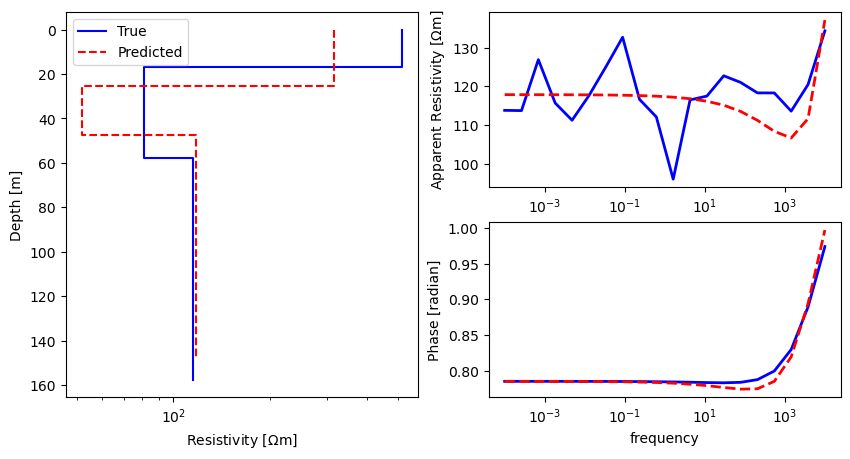

misfit =  71.859 %


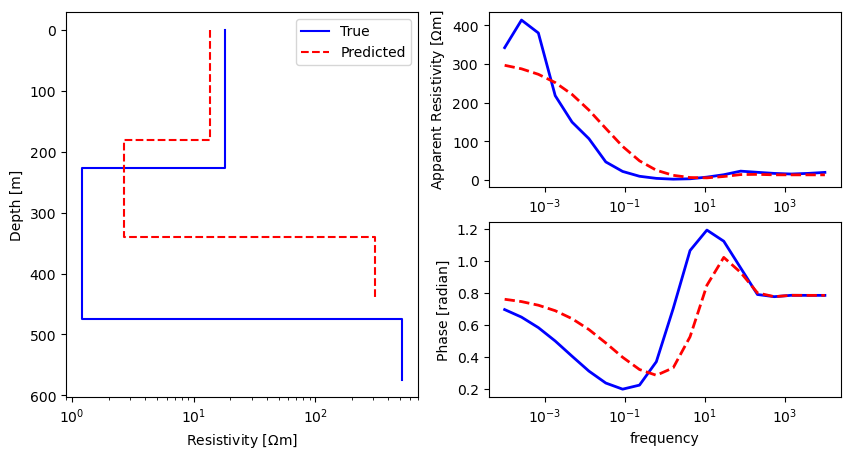

In [15]:
# test on the new data

Y_test = df3[col_name[0:5]]
X_test = df3[col_name[5:]]

# best and worse prediction from test dataset
for id_pred_test in df_min_max_test:
    
    y_pred = model.predict(X_test.iloc[[id_pred_test]])

#     print(len(y_pred))
    df_pred,misfit,df_min_max = eval_misfit(y_pred,X_test.iloc[[id_pred_test]].reset_index(drop=True))

    print('misfit = ',misfit,'%')
    
    compare_forward_response(y_pred.reshape(-1),X_test.iloc[id_pred_test],Y_test.iloc[id_pred_test])
    plt.show()